# Data pre process

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
DataFrame = pd.read_excel('./DataSets/Raw_Building_energy.xlsx', header=1)

### Basic Info of the data frame 

In [2]:
DataFrame.head()

,Time,reading
0,2021-01-27 11:00:00,8.03 kWh
1,2021-01-27 12:00:00,6.85 kWh
2,2021-01-27 13:00:00,8.86 kWh
3,2021-01-27 14:00:00,7.37 kWh
4,2021-01-27 15:00:00,7.67 kWh


In [3]:
DataFrame.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6726 entries, 0 to 6725
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Time     6726 non-null   object
 1   reading  6726 non-null   object
dtypes: object(2)
memory usage: 105.2+ KB


In [4]:
DataFrame.columns 

Index(['Time', 'reading'], dtype='object')

In [5]:
print(DataFrame['Time'])

0       2021-01-27 11:00:00
1       2021-01-27 12:00:00
2       2021-01-27 13:00:00
3       2021-01-27 14:00:00
4       2021-01-27 15:00:00
               ...         
6721    2021-11-03 12:00:00
6722    2021-11-03 13:00:00
6723    2021-11-03 14:00:00
6724    2021-11-03 15:00:00
6725    2021-11-03 16:00:00
Name: Time, Length: 6726, dtype: object


In [6]:
type(DataFrame['Time'][0])

str

### Removing Units from Reading column

For the input we need a valid integer value, without any string

In [7]:

reading  = [float(s.replace(" kWh",'')) for s in DataFrame['reading']]
#Insert the new values without the units
DataFrame.insert(1, 'Energy Usage',reading)

#Remove the old one
DataFrame.drop('reading', inplace = True, axis=1) 

#check 
DataFrame.head()

,Time,Energy Usage
0,2021-01-27 11:00:00,8.03
1,2021-01-27 12:00:00,6.85
2,2021-01-27 13:00:00,8.86
3,2021-01-27 14:00:00,7.37
4,2021-01-27 15:00:00,7.67


### Plots 

#### Plot Energy Usage

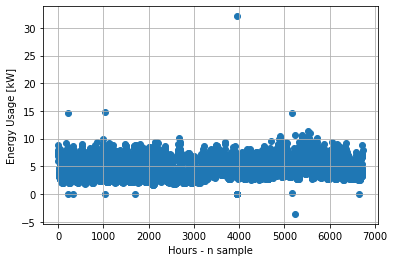

In [8]:
plt.scatter(DataFrame.index,DataFrame['Energy Usage'])
plt.xlabel('Hours - n sample')
plt.ylabel("Energy Usage [kW]")
plt.grid() 


#### Energy Usage distribution

<Figure size 432x288 with 0 Axes>

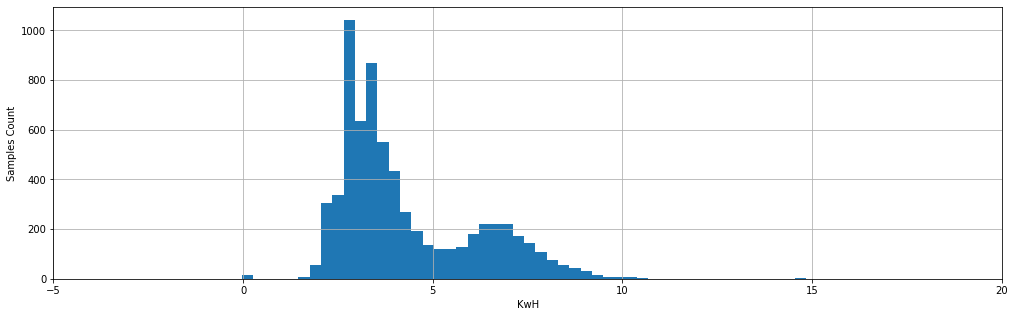

In [9]:
plt.figure()
plt.figure(figsize=(17, 5))
plt.hist(DataFrame['Energy Usage'], bins=120) 
plt.xlabel("KwH")
plt.ylabel("Samples Count")
plt.grid('--')
plt.xlim([-5,20])
plt.show()

* Zoom

<Figure size 432x288 with 0 Axes>

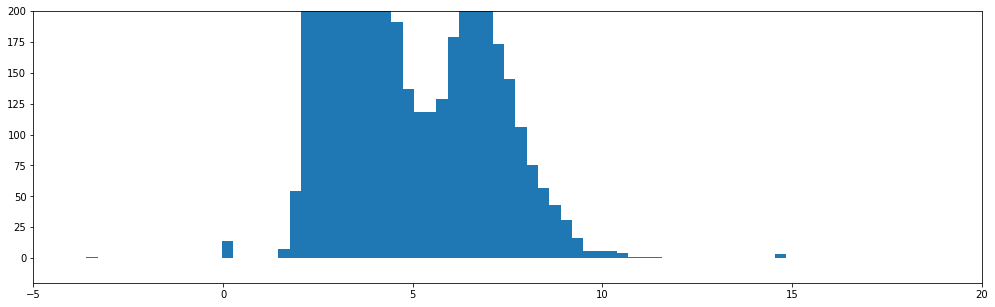

In [10]:
plt.figure()
plt.figure(figsize=(17, 5))
plt.hist(DataFrame['Energy Usage'], bins=120) 

plt.xlim([-5,20])
plt.ylim([-20,200])
plt.show()
#looks like a Gaussian 

* Gaussian vs our *Energy Usage* distribution

<Figure size 432x288 with 0 Axes>

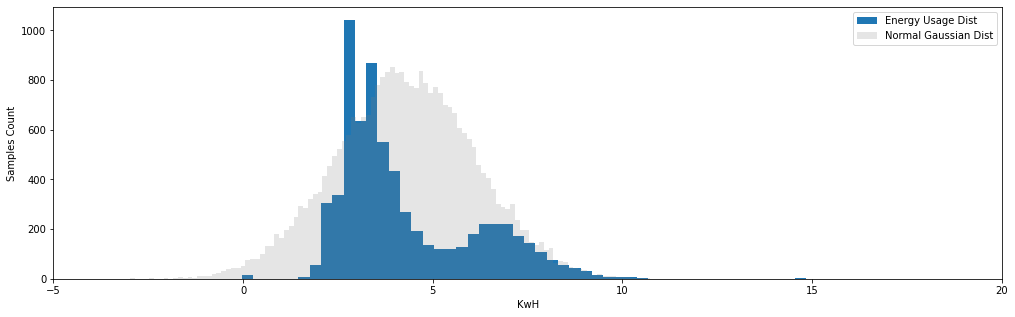

In [11]:
mu = np.mean(DataFrame['Energy Usage'])
std = np.std(DataFrame['Energy Usage'])

datos = np.random.normal(mu, std, 30000) #creando muestra de datos


plt.figure()
plt.figure(figsize=(17, 5))
plt.hist(DataFrame['Energy Usage'], bins=120, label="Energy Usage Dist")
plt.hist(datos,bins=120,alpha=.2,color='gray',lw=.75,linestyle=':',label="Normal Gaussian Dist")
#plot the limits and de mean 
#plt.plot(mu,1500)
#
plt.xlabel("KwH")
plt.ylabel("Samples Count")
plt.legend()
plt.xlim([-5,20])
plt.show()



### Finding the anomalies 

We've considered anomalies the data point outside of 4sigma of the normal gaussian distribution. 
More explanation ...


we consider 0 (not a oulier) as anamolie

* We create a function `find_anomalies` to detect the anomalies and return the value and the location of each of them on the data frame


In [12]:
def find_anomalies(data):
    #define a list to accumlate anomalies
    anomalies = []
    idx_anomalies = []
    
   
    # Set upper and lower limit to 4 standard deviation
    data_std = np.std(data)
    data_mean = np.mean(data)
    anomaly_cut_off = data_std * 4
    lower_limit  = data_mean - anomaly_cut_off 
    upper_limit = data_mean + anomaly_cut_off

    # Generate outliers
    for idx,outlier in enumerate(data):
        if outlier > upper_limit or outlier < lower_limit or outlier ==0: 
            anomalies.append(outlier)
            idx_anomalies.append(idx)
          
        
    return anomalies, idx_anomalies


In [13]:
anomalies, idx_anomalies = find_anomalies(DataFrame["Energy Usage"])
print(anomalies)
print(idx_anomalies)

[0.0, 14.7, 0.0, 0.0, 14.8, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.1, 14.7, -3.6, 0.0]
[217, 218, 320, 1034, 1035, 1695, 3949, 3950, 3951, 3952, 3953, 3954, 3955, 3956, 3957, 5158, 5222, 6639]


### Replacing the anomalies

as we have consecutives values considered anomalies, we can't do linear interpolation (check this) 

* In order to use the built-in function of pandas, we assign a NaN to every anomaly

In [14]:
def replace_anomalies(data,idx_anomalies,col): 
    for index in idx_anomalies: 
        #DataFrame["Energy Usage"][index] = DataFrame["Energy Usage"][index-1] +  DataFrame["Energy Usage"][index+1] / 2 
        data[col][index] = np.nan
        
    return data

In [15]:
DataFrame= replace_anomalies(DataFrame,idx_anomalies,'Energy Usage')

/tmp/ipykernel_198049/3520209725.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col][index] = np.nan


In [16]:
DataFrame["Energy Usage"][3945:3960]

3945    3.26
3946    3.58
3947    3.80
3948    3.88
3949     NaN
3950     NaN
3951     NaN
3952     NaN
3953     NaN
3954     NaN
3955     NaN
3956     NaN
3957     NaN
3958    3.19
3959    3.20
Name: Energy Usage, dtype: float64

* Using the interpolate function

In [17]:
DataFrame.interpolate(method='bfill',inplace=True) #or ffil 

In [18]:
DataFrame["Energy Usage"][3945:3960]

3945    3.26
3946    3.58
3947    3.80
3948    3.88
3949    3.19
3950    3.19
3951    3.19
3952    3.19
3953    3.19
3954    3.19
3955    3.19
3956    3.19
3957    3.19
3958    3.19
3959    3.20
Name: Energy Usage, dtype: float64

* Check if we have more anomalies left

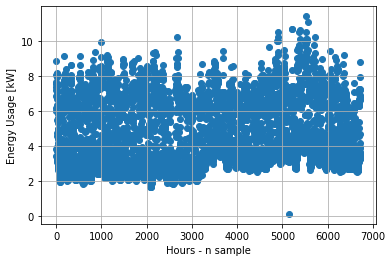

In [19]:
plt.scatter(DataFrame.index,DataFrame['Energy Usage'])
plt.xlabel('Hours - n sample')
plt.ylabel("Energy Usage [kW]")
plt.grid() 

### Save the pre-processed dataSet of Building Energy consumption 

In [20]:
def SaveDataFrame(data, name): 
    data.to_csv(name,index=False)
    return 

In [21]:
SaveDataFrame(DataFrame,"./DataSets/PreProcessed_EnergyConsumption.csv")